# CITEseq data analysis
*Author: Lena Boehme, Taghon lab, 2024*

## Pseudotemporal expression profiling


Pseudotime for CD4 and CD8 lineage cells was already determine during the annotation process. We can now utilise this to assess the expression kinetics of markers/genes of interest and compared how these relate between the two lineages.

### Setup

In [3]:
options(repr.plot.width=12, repr.plot.height=6)

options(scipen=100) #avoid scientific notation of numbers

library(SeuratDisk)
library(Seurat)
library(matrixStats)
library(ggplot2)
library(pheatmap)
library(reshape2)
library(dplyr)
library(tidyr)
library(viridis)
library(RColorBrewer)
library(stringr)
library(pals)

library(batchelor)
library(BiocParallel)
library(BiocNeighbors)
library(slingshot)
library(SingleCellExperiment)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching SeuratObject


Attaching package: ‘dplyr’


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths


Loading required package: viridisLite


Attaching package: ‘pals’


The following objects are masked from ‘package:viridis’:

    cividis, inferno, magma, plasma, turbo, viridis


The following objects are masked from ‘package:viridisLite’:

    cividis, inferno, magma, plasma, turbo, viridis


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics


Attaching package: ‘MatrixGenerics’


The following objects are

In [3]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Brussels
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] slingshot_2.10.0            TrajectoryUtils_1.10.0     
 [3] princurve_2.1.6             BiocNeighbors_1.20.1       
 [5] BiocParallel_1.36.0         batchelor_1.18.1           
 [7] SingleC

In [4]:
setwd("")

In [5]:
pal24 <- colorRampPalette(brewer.pal(12, "Paired"))(24)
pal36 <- colorRampPalette(brewer.pal(12, "Paired"))(36)
pal12 <- colorRampPalette(brewer.pal(12, "Paired"))(12)
pal60 <- colorRampPalette(brewer.pal(12, "Paired"))(60)
pal40 <- colorRampPalette(brewer.pal(12, "Paired"))(40)
pal8 <- brewer.paired(8)
pal10 <- brewer.paired(10)

We will work with the 'clean' seurat object that only contains cells with unambiguous CITE-seq-derived annotations.

In [5]:
seurObj <- LoadH5Seurat('./HTSA_CITE_anno_clean.h5seurat')

Validating h5Seurat file

Initializing ADT with data

Adding counts for ADT

Adding miscellaneous information for ADT

Initializing ADTdsb with data

Adding scale.data for ADTdsb

Adding feature-level metadata for ADTdsb

Adding variable feature information for ADTdsb

Adding miscellaneous information for ADTdsb

Initializing ADTdsbneg with data

Adding miscellaneous information for ADTdsbneg

Initializing RNA with data

Adding counts for RNA

Adding scale.data for RNA

Adding feature-level metadata for RNA

Adding variable feature information for RNA

Adding miscellaneous information for RNA

Initializing RNA_cellranger with data

Adding counts for RNA_cellranger

Adding miscellaneous information for RNA_cellranger

Adding reduction mnn_adt

Adding cell embeddings for mnn_adt

Adding miscellaneous information for mnn_adt

Adding reduction mnn_adt2

Adding cell embeddings for mnn_adt2

Adding miscellaneous information for mnn_adt2

Adding reduction pca_adt

Adding cell embeddings for p

In [6]:
seurObj

An object of class Seurat 
73652 features across 136008 samples within 5 assays 
Active assay: ADTdsb (150 features, 150 variable features)
 2 layers present: data, scale.data
 4 other assays present: ADT, ADTdsbneg, RNA, RNA_cellranger
 18 dimensional reductions calculated: mnn_adt, mnn_adt2, pca_adt, pca_adt2, umap_adt, umap_adt_mnn, umap_wnn_mnn2, mnn_rna, mnn_rna2, pca_rna, pca_rna2, scVI, spca, umap, umap_rna, umap_rna_mnn, umap_wnn, umap_wnn_mnn

In [7]:
table(is.na(seurObj$spt_CD4), is.na(seurObj$spt_CD8))

       
         FALSE   TRUE
  FALSE  18149  10753
  TRUE    6378 100728

In [8]:
seurObj_SP <- subset(seurObj, subset=anno_CITE_new %in% c('DP_pos_sel', 'DP_4hi8lo', 'SP_CD4_immature', 'SP_CD4_semimature', 'SP_CD4_mature', 'SP_CD8_immature', 'SP_CD8_semimature', 'SP_CD8_mature')) %>% 
               subset(., cells = seurObj@meta.data[is.na(seurObj$spt_CD4) & is.na(seurObj$spt_CD8), "barcode"], invert=T)


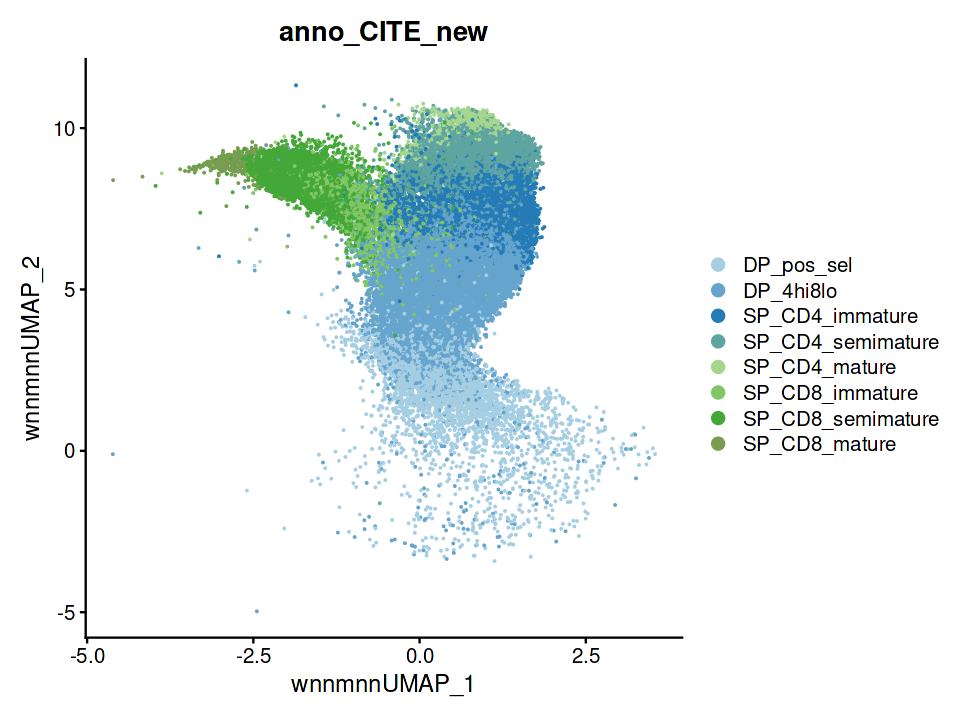

In [9]:
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(seurObj_SP, reduction = 'umap_wnn_mnn', group.by = 'anno_CITE_new', cols=(pal24), shuffle=T, raster=F)

In [10]:
ADT.df <- seurObj_SP@assays$ADTdsb@data %>% t %>% data.frame %>% cbind(.,
                                                                       spt_CD4=seurObj_SP$spt_CD4,
                                                                       spt_CD4_old=seurObj_SP$spt_CD4_old,
                                                                       spt_CD8=seurObj_SP$spt_CD8,
                                                                       spt_CD8_old=seurObj_SP$spt_CD8_old,
                                                                       anno_CITE_old=seurObj_SP$anno_CITE_old,
                                                                       anno_CITE_new=seurObj_SP$anno_CITE_new)

ADT.df %>% head

,CD101,CD103,CD105,CD107a,CD112,CD119,CD11a,CD11b,CD11c,CD122,⋯,NOTCH3,TCRgd,TCRVa24.Ja18,XCR1,spt_CD4,spt_CD4_old,spt_CD8,spt_CD8_old,anno_CITE_old,anno_CITE_new
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
GEX1-GGCTGGTGTATTCTCT,6.664818,1.6324821,11.246661,14.161578,4.151866,4.026426,10.44134,3.95316498,0.8931085,6.567885,⋯,4.9306664,1.9478098,0.6521868,0.5579327,2.1068390,NA,2.1521830,NA,DP(Q)_rearr,DP_pos_sel
GEX1-GTTCGGGCAGTCAGCC,6.454829,0.0000000,3.925648,15.188752,11.456454,11.249458,12.29764,0.07694084,0.0000000,12.506349,⋯,0.2494044,3.5206888,1.3778636,0.0000000,0.0000000,NA,0.0000000,NA,DP(Q)_rearr,DP_pos_sel
GEX1-AGCTCTCAGGAATGGA,5.850083,4.3998840,5.112020,12.788000,4.311187,4.244524,9.09126,8.16331484,0.9714368,5.287886,⋯,1.9688667,3.2684198,0.7199370,0.6086563,1.4907172,NA,1.4825825,NA,unknown,DP_pos_sel
GEX1-CATATTCTCCTCGCAT,10.028103,0.3053877,3.554996,30.472501,8.928240,10.634537,12.09889,5.04098748,0.0000000,5.312528,⋯,4.4639891,10.6137106,9.4870624,0.0000000,1.2822185,NA,1.2876407,NA,unknown,DP_pos_sel
GEX1-TTTATGCTCAGTTTGG,5.353328,6.2211904,5.715814,7.106843,1.087708,9.027408,10.31282,3.53928986,0.6889135,6.106052,⋯,1.8086393,0.3864483,0.4755679,8.1743812,0.8259254,NA,0.8256177,NA,DP(Q)_rearr,DP_pos_sel
GEX1-ACGAGGATCCTCAATT,5.620820,8.1628294,8.328098,5.563377,8.540051,7.436969,11.83715,5.39360799,0.5626700,4.363367,⋯,4.7432650,1.6274157,0.3663733,0.3439485,2.6453301,NA,3.2120053,NA,unknown,DP_4hi8lo


In [5]:
ADT.df <- seurObj_SP@assays$ADTdsb@data %>% t %>% data.frame %>% cbind(.,
                                                                       spt_CD4=seurObj_SP$spt_CD4,
                                                                       spt_CD8=seurObj_SP$spt_CD8,
                                                                       anno_CITE_new=seurObj_SP$anno_CITE_new)

ADT.df %>% head

,CD101,CD103,CD105,CD107a,CD112,CD119,CD11a,CD11b,CD11c,CD122,⋯,CD357,CD370,NOTCH1,NOTCH3,TCRgd,TCRVa24.Ja18,XCR1,spt_CD4,spt_CD8,anno_CITE_new
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
GEX1-GGCTGGTGTATTCTCT,6.664818,1.6324821,11.246661,14.161578,4.151866,4.026426,10.44134,3.95316498,0.8931085,6.567885,⋯,0.9243930,2.8540825,4.603796,4.9306664,1.9478098,0.6521868,0.5579327,2.1068390,2.1521830,DP_pos_sel
GEX1-GTTCGGGCAGTCAGCC,6.454829,0.0000000,3.925648,15.188752,11.456454,11.249458,12.29764,0.07694084,0.0000000,12.506349,⋯,0.0000000,17.3574080,3.694206,0.2494044,3.5206888,1.3778636,0.0000000,0.0000000,0.0000000,DP_pos_sel
GEX1-AGCTCTCAGGAATGGA,5.850083,4.3998840,5.112020,12.788000,4.311187,4.244524,9.09126,8.16331484,0.9714368,5.287886,⋯,1.0108272,0.8853202,2.525337,1.9688667,3.2684198,0.7199370,0.6086563,1.4907172,1.4825825,DP_pos_sel
GEX1-CATATTCTCCTCGCAT,10.028103,0.3053877,3.554996,30.472501,8.928240,10.634537,12.09889,5.04098748,0.0000000,5.312528,⋯,15.1350078,3.0327357,2.620678,4.4639891,10.6137106,9.4870624,0.0000000,1.2822185,1.2876407,DP_pos_sel
GEX1-TTTATGCTCAGTTTGG,5.353328,6.2211904,5.715814,7.106843,1.087708,9.027408,10.31282,3.53928986,0.6889135,6.106052,⋯,0.6990670,0.5809378,2.403087,1.8086393,0.3864483,0.4755679,8.1743812,0.8259254,0.8256177,DP_pos_sel
GEX1-ACGAGGATCCTCAATT,5.620820,8.1628294,8.328098,5.563377,8.540051,7.436969,11.83715,5.39360799,0.5626700,4.363367,⋯,0.5597592,0.4449267,3.851281,4.7432650,1.6274157,0.3663733,0.3439485,2.6453301,3.2120053,DP_4hi8lo


Warning message:
“Removed 6375 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 10749 rows containing missing values (`geom_point()`).”


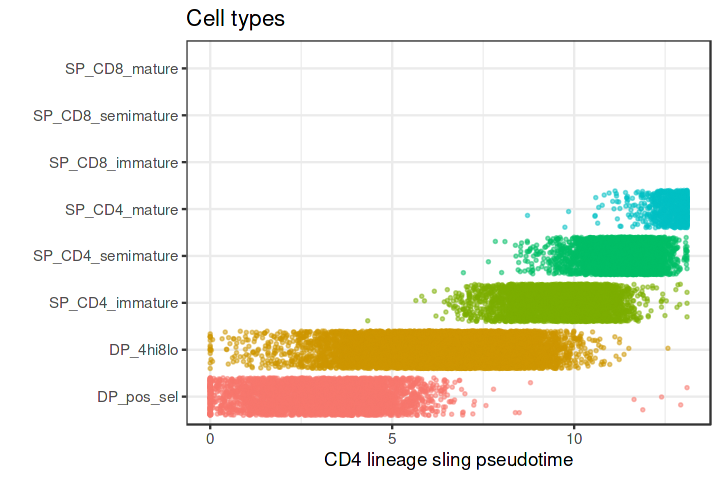

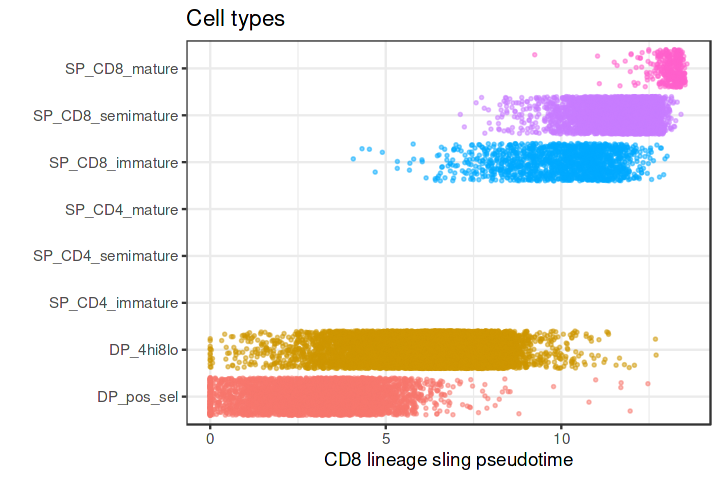

In [11]:
options(repr.plot.width=6, repr.plot.height=4)

ggplot(ADT.df, aes(y= anno_CITE_new, x=spt_CD4, color=anno_CITE_new))+
geom_jitter(size=0.5, alpha=0.5)+
theme_bw()+
labs(title='Cell types', y='', x='CD4 lineage sling pseudotime')&NoLegend()

ggplot(ADT.df, aes(y= anno_CITE_new, x=spt_CD8, color=anno_CITE_new))+
geom_jitter(size=0.5, alpha=0.5)+
theme_bw()+
labs(title='Cell types', y='', x='CD8 lineage sling pseudotime')&NoLegend()

Remove DP_pos_sel with pseudotime > 7.7 and 4hi8lo with pseudotime ~0.

In [12]:
seurObj_SP2 <- subset(seurObj_SP, subset = ((spt_CD4 < 0.1 | spt_CD8 < 0.1) & anno_CITE_new =='DP_4hi8lo'), invert=T) %>%
                subset(., subset = ((spt_CD4 > 7.5 | spt_CD8 > 7.5) & anno_CITE_new =='DP_pos_sel'), invert=T)


In [6]:
expr.df <- seurObj_SP2@assays$ADTdsb@data %>% t %>% data.frame %>% cbind(.,
                                                                       spt_CD4=seurObj_SP2$spt_CD4,
                                                                       spt_CD8=seurObj_SP2$spt_CD8,
                                                                       anno_CITE_new=seurObj_SP2$anno_CITE_new,
                                                                       data.frame(t(seurObj_SP2@assays$RNA@data[rownames(seurObj_SP2@assays$RNA@data) %in% c('CXCR3', 'CXCR4','CCR4', 'CCR6', 'CCR7', 'CCR8', 'CCR9'),])))

Warning message:
“Removed 7016 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 11390 rows containing missing values or values outside the scale range
(`geom_point()`).”


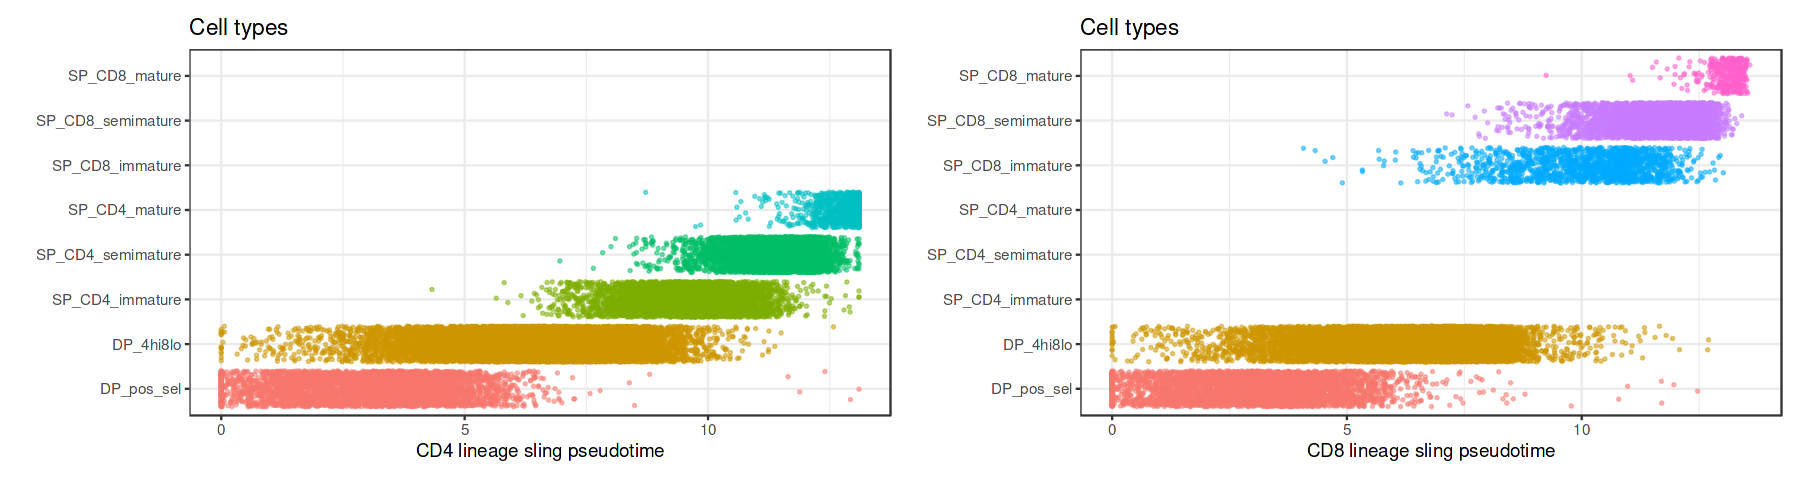

In [7]:
options(repr.plot.width=6, repr.plot.height=4)

lineage4 <- ggplot(expr.df, aes(y= anno_CITE_new, x=spt_CD4, color=anno_CITE_new))+
geom_jitter(size=0.5, alpha=0.5)+
theme_bw()+
labs(title='Cell types', y='', x='CD4 lineage sling pseudotime')&NoLegend()

lineage8 <- ggplot(expr.df, aes(y= anno_CITE_new, x=spt_CD8, color=anno_CITE_new))+
geom_jitter(size=0.5, alpha=0.5)+
theme_bw()+
labs(title='Cell types', y='', x='CD8 lineage sling pseudotime')&NoLegend()

options(repr.plot.width=15, repr.plot.height=4)
(lineage4 + lineage8)

In [15]:
colors_rna <- c("CD4" = "red", "CD8A" = "blue", "CD8B" = "green3")
colors_protein <- c("CD4" = "red", "CD8" = "blue")

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 11390 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 11390 rows containing non-finite outside the scale range
(`stat_smooth()`).”


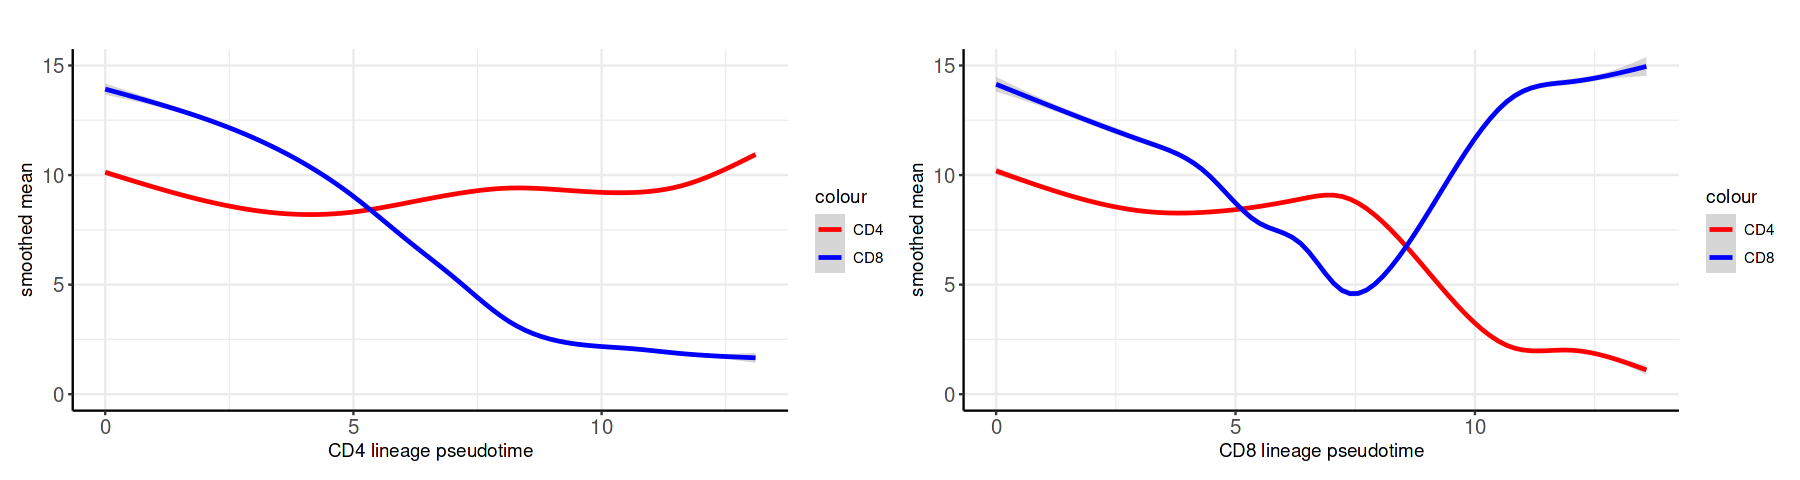

In [10]:
lineage4_prot <- ggplot(expr.df)+
geom_smooth(aes(y=CD4, x=spt_CD4, color='CD4'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD8, x=spt_CD4, color='CD8'), se=TRUE, method = 'gam')+
theme_bw()+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 12),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+
scale_color_manual(values = colors_protein)+
coord_cartesian(ylim = c(0,15))+
labs(title='', y='smoothed mean', x='CD4 lineage pseudotime')

lineage8_prot <- ggplot(expr.df)+
geom_smooth(aes(y=CD4, x=spt_CD8, color='CD4'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD8, x=spt_CD8, color='CD8'), se=TRUE, method = 'gam')+
theme_bw()+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 12),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+
scale_color_manual(values = colors_protein)+
coord_cartesian(ylim = c(0,15))+
labs(title='', y='smoothed mean', x='CD8 lineage pseudotime')

options(repr.plot.width=15, repr.plot.height=4)
(lineage4_prot + lineage8_prot)

In [17]:
colors_receptors_prot <- c('CD183' ='red',
                           'CD194'='black',
                           'CD197'='green3',
                           'CD199'='dodgerblue')

colors_receptors_rna <- c('CXCR3' ='red',
                           'CCR4'='black',
                           'CCR7'='green3',
                           'CCR9'='dodgerblue',
                           'CXCR4'='purple')

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning me

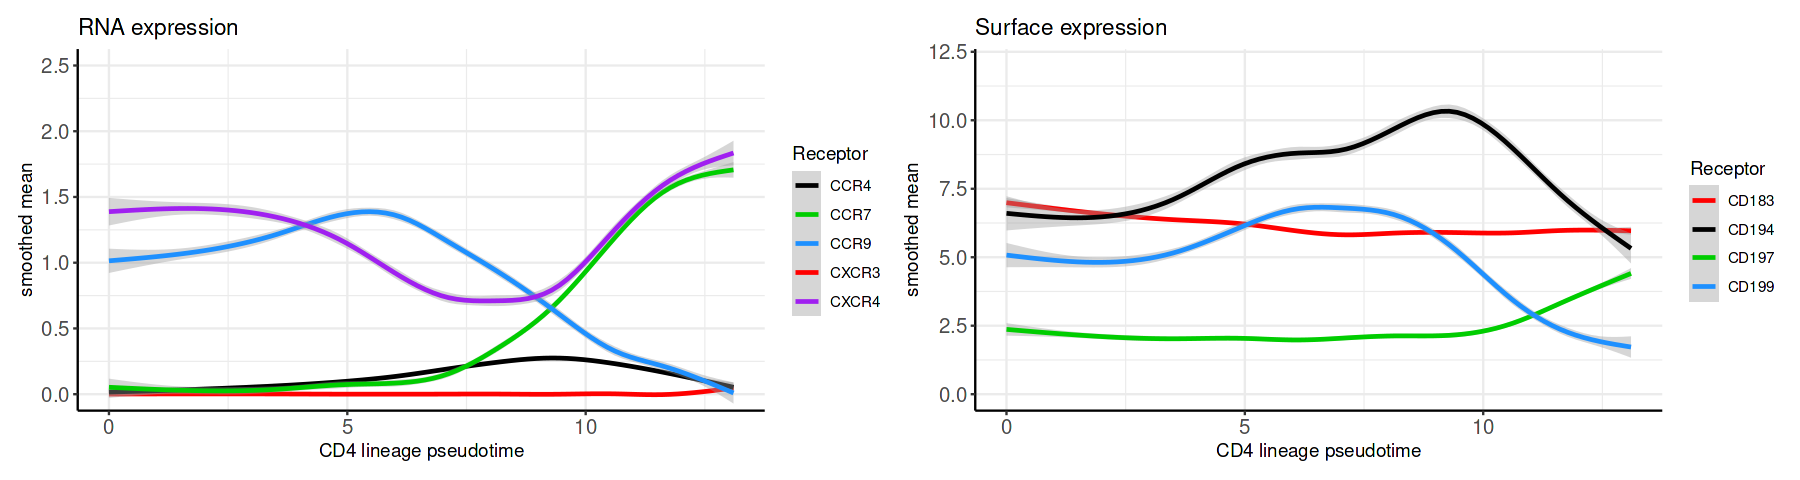

In [12]:
receptors_lineage4_prot <- ggplot(expr.df)+
geom_smooth(aes(y=CD183, x=spt_CD4, color='CD183'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD194, x=spt_CD4, color='CD194'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD197, x=spt_CD4, color='CD197'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD199, x=spt_CD4, color='CD199'), se=TRUE, method = 'gam')+
theme_bw()+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 12),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+
scale_color_manual(values = colors_receptors_prot)+
coord_cartesian(ylim = c(0,12))+
theme(legend.key = element_rect(fill = "white"))+
labs(title='Surface expression', y='smoothed mean', x='CD4 lineage pseudotime', color='Receptor')

receptors_lineage4_rna <- ggplot(expr.df)+
geom_smooth(aes(y=CXCR3, x=spt_CD4, color='CXCR3'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CCR4, x=spt_CD4, color='CCR4'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CCR7, x=spt_CD4, color='CCR7'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CCR9, x=spt_CD4, color='CCR9'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CXCR4, x=spt_CD4, color='CXCR4'), se=TRUE, method = 'gam')+
theme_bw()+
coord_cartesian(ylim = c(0,2.5))+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 12),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+
scale_color_manual(values = colors_receptors_rna)+
theme(legend.key = element_rect(fill = "white"))+
labs(title='RNA expression', y='smoothed mean', x='CD4 lineage pseudotime', color='Receptor')

options(repr.plot.width=15, repr.plot.height=4)
(receptors_lineage4_rna + receptors_lineage4_prot)

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 11390 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 11390 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 11390 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 11390 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 11390 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 11390 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warn

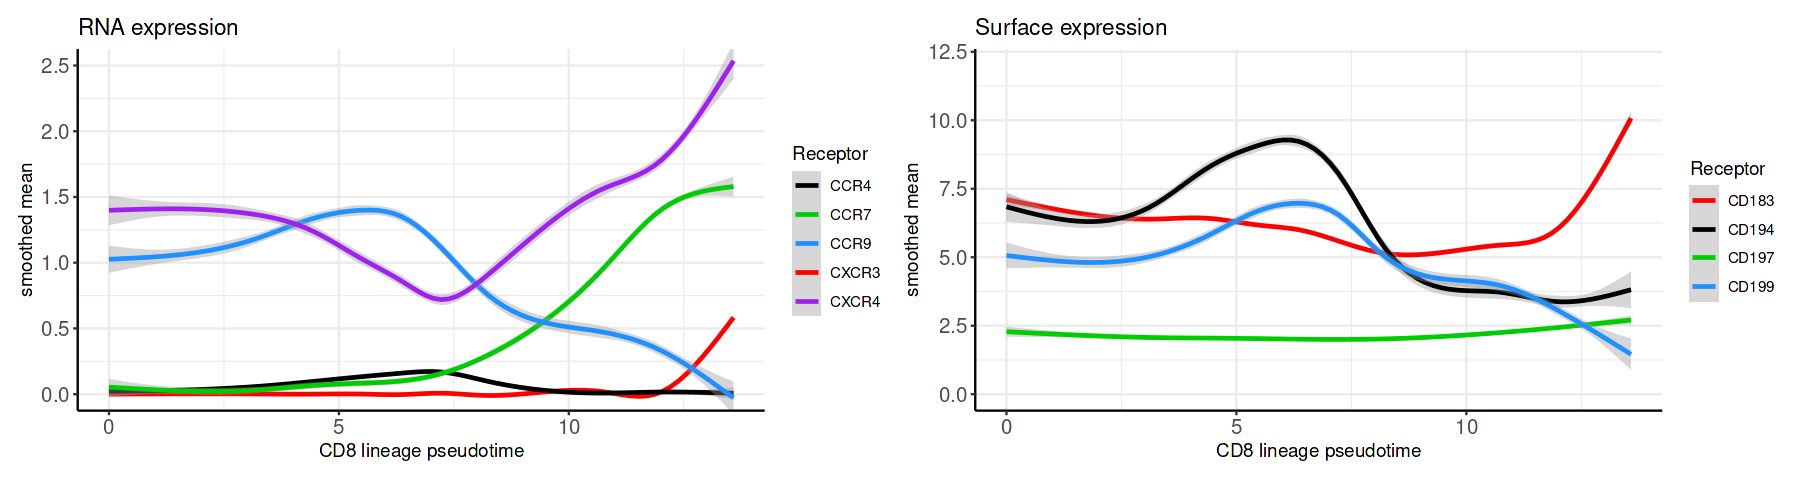

In [14]:
receptors_lineage8_prot <- ggplot(expr.df)+
geom_smooth(aes(y=CD183, x=spt_CD8, color='CD183'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD194, x=spt_CD8, color='CD194'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD197, x=spt_CD8, color='CD197'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD199, x=spt_CD8, color='CD199'), se=TRUE, method = 'gam')+
theme_bw()+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 12),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+
scale_color_manual(values = colors_receptors_prot)+
coord_cartesian(ylim = c(0,12))+
theme(legend.key = element_rect(fill = "white"))+
labs(title='Surface expression', y='smoothed mean', x='CD8 lineage pseudotime', color='Receptor')

receptors_lineage8_rna <- ggplot(expr.df)+
geom_smooth(aes(y=CXCR3, x=spt_CD8, color='CXCR3'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CCR4, x=spt_CD8, color='CCR4'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CCR7, x=spt_CD8, color='CCR7'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CCR9, x=spt_CD8, color='CCR9'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CXCR4, x=spt_CD8, color='CXCR4'), se=TRUE, method = 'gam')+
theme_bw()+
coord_cartesian(ylim = c(0,2.5))+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 12),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+
scale_color_manual(values = colors_receptors_rna)+
theme(legend.key = element_rect(fill = "white"))+
labs(title='RNA expression', y='smoothed mean', x='CD8 lineage pseudotime', color='Receptor')

options(repr.plot.width=15, repr.plot.height=4)
(receptors_lineage8_rna + receptors_lineage8_prot)

In [20]:
colors_protein2 <- c('CD1a'='red',
                    'CD44'='blue',
                    'CD45RA'='green3',
                    'CD45RO'='orange',
                    'CD27'='black',
                    'CD69'='purple',
                    'TCRab'='blue')

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 7016 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning me

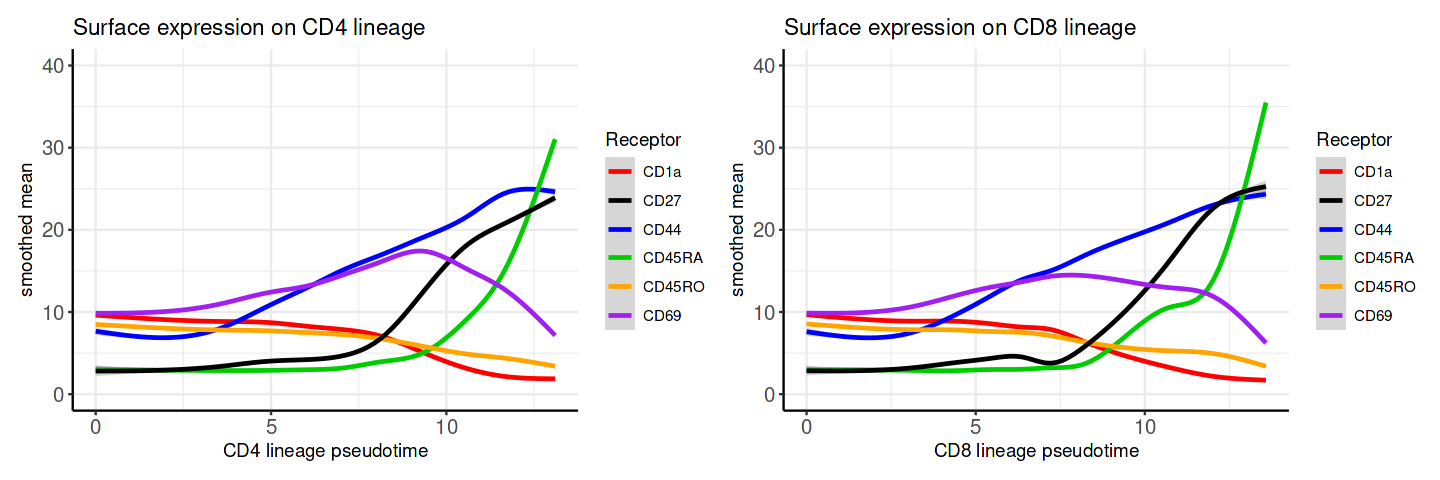

In [16]:
markers_lineage4 <- ggplot(expr.df)+
geom_smooth(aes(y=CD1a, x=spt_CD4, color='CD1a'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD44, x=spt_CD4, color='CD44'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD45RA, x=spt_CD4, color='CD45RA'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD45RO, x=spt_CD4, color='CD45RO'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD27, x=spt_CD4, color='CD27'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD69, x=spt_CD4, color='CD69'), se=TRUE, method = 'gam')+
theme_bw()+
coord_cartesian(ylim = c(0,40))+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 12),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+
scale_color_manual(values = colors_protein2)+
theme(legend.key = element_rect(fill = "white"))+
labs(title='Surface expression on CD4 lineage', y='smoothed mean', x='CD4 lineage pseudotime', color='Receptor')

markers_lineage8 <- ggplot(expr.df)+
geom_smooth(aes(y=CD1a, x=spt_CD8, color='CD1a'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD44, x=spt_CD8, color='CD44'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD45RA, x=spt_CD8, color='CD45RA'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD45RO, x=spt_CD8, color='CD45RO'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD27, x=spt_CD8, color='CD27'), se=TRUE, method = 'gam')+
geom_smooth(aes(y=CD69, x=spt_CD8, color='CD69'), se=TRUE, method = 'gam')+
theme_bw()+
coord_cartesian(ylim = c(0,40))+
theme(axis.text.x = element_text(size=12), axis.text.y = element_text(size = 12),
           panel.border = element_blank(), axis.line.x = element_line(size = 0.5, linetype = "solid", colour = "black"),
axis.line.y = element_line(size = 0.5, linetype = "solid", colour = "black"))+
scale_color_manual(values = colors_protein2)+
theme(legend.key = element_rect(fill = "white"))+
labs(title='Surface expression on CD8 lineage', y='smoothed mean', x='CD8 lineage pseudotime', color='Receptor')

options(repr.plot.width=12, repr.plot.height=4)

(markers_lineage4 + markers_lineage8)